# Solar Flare Data Analysis and Visualization

## Aim
To explore, visualize, and analyze solar flare events using the SWAN dataset, focusing on the relationship between magnetic parameters and flare activity.

---

Library Imports

In [1]:
%pip install mplcursors -q

In [2]:
import requests
import tarfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib.dates as mdates
from matplotlib.ticker import LogLocator
import seaborn as sns
from datetime import datetime
import mplcursors
import plotly.express as px
from plotly.subplots import make_subplots

## Step 1: Downloading the Data
---

This assignment will only be using [Partition 1](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/BMXYCB),

A paper describing the construction of the dataset can be found [here](https://doi.org/10.1038/s41597-020-0548-x).

---

Individual partitions of the dataset can be accessed through following links:
- [Partition 1](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/BMXYCB) - 1.2GB
- [Partition 2](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/TCRPUD) - 1.4GB
- [Partition 3](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/PTPGQT) - 702.1 MB
- [Partition 4](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/FIFLFU) - 844.4 MB
- [Partition 5](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/QC2C3X) - 1.2 GB

---

### Dataset Attributes:

Each file in the dataset contains the following attributes as a single variate of the multivariate timeseries (MVTS) sample.

|              |                  |             |
|--------------|------------------|-------------|
| 1. Timestamp | 2. TOTUSJH       | 3. TOTBSQ   |
| 4. TOTPOT	   | 5. TOTUSJZ       | 6. ABSNJZH  |
| 7. SAVNCPP   | 8. USFLUX        | 9. TOTFZ	|
| 10. MEANPOT  | 11. EPSZ	      | 12. MEANSHR |
| 13. SHRGT45  | 14. MEANGAM      | 15. MEANGBT |
| 16. MEANGBZ  | 17. MEANGBH      | 18. MEANJZH |
| 19. TOTFY    | 20. MEANJZD      | 21. MEANALP |
| 22. TOTFX    | 23. EPSY	      | 24. EPSX	|
| 25. R_VALUE  | 26. CRVAL1       | 27. CRLN_OBS|
| 28. CRLT_OBS | 29. CRVAL2       | 30. HC_ANGLE|
| 31. SPEI     | 32. LAT_MIN      | 33. LON_MIN |
| 34. LAT_MAX  | 35. LON_MAX      | 36. QUALITY |
| 37. BFLARE   | 38. BFLARE_LABEL |	39. CFLARE  |
| 39. CFLARE_LABEL | 40. MFLARE | 41. MFLARE_LABEL |
| 42. XFLARE | 43. XFLARE_LABEL | 44. BFLARE_LOC |
| 45. BFLARE_LABEL_LOC | 46. CFLARE_LOC | 47. CFLARE_LABEL_LOC |
| 48. MFLARE_LOC | 49. MFLARE_LABEL_LOC | 50. FLARE_LOC |
| 51. XFLARE_LABEL_LOC | 52. XR_MAX | 53. XR_QUAL |
|54. IS_TMFI | | |

---

In [3]:
url = "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/BMXYCB"
response = requests.get(url)
with open("dataset.tar.gz", "wb") as f:
   f.write(response.content)

with tarfile.open("dataset.tar.gz", "r:gz") as tar:
   tar.extractall()

os.remove("dataset.tar.gz")

In [4]:
csv_files = glob.glob("partition1/NF/*.csv") + glob.glob("partition1/FL/*.csv")
df_list = [pd.read_csv(file, sep='\t') for file in csv_files]
df_swan_actual = pd.concat(df_list, ignore_index=True)

## About the data
---

The __partition1__ direcotry contains two subdirectories, __FL__ and __NF__, these subdirectories represent the two classes of our target feature in the solar flare prediction problem we will be attempting to solve this semester.

- __FL__: Represents the multivariate time series samples that have a Solar Flare occur within 24 hours of the observation.
- __NF__: Represents the multivariate time series samples that do not have a Solar Flare occur within 24 hours of the observation.

The multivariate time series samples are stored in .csv files for each individual sample. Each file name contains a number of pieces of information that we will wish to keep for our prediction task and therefore should be part of your Analytics Base Table. Below are examples of the naming for each sample type.

- __FL__ file name example:`M1.0@265:Primary_ar115_s2010-08-06T06:36:00_e2010-08-06T18:24:00.csv`
- __NF__ file name example:`FQ_ar99_s2010-08-01T19:00:00_e2010-08-02T06:48:00.csv` or `B1.9@909:Primary_ar325_s2011-01-04T02:36:00_e2011-01-04T14:24:00.csv`

Let's look at these formats, starting with those that contain an `@` symbol (we will use the __FL__ file as an example but note that the __NF__ data also has files with this naming):
- __M1.0@265:Primary__: This says that there occurs an M1.0 sized flare within 24 hours of our sample. It also says that this flare is numbered 265 in the accompanying integrated flare dataset that comes as a supplementary file to this dataset. Additionally, "Primary" indicates that the intersection with this active region was verified through the primary method described in the paper.  
- __\_ar115__: This indicates which active region (`_ar`) the sample comes from in the original unsampled dataset.
- __\_s2010-08-06T06:36:00__: This is the start time (`_st`) of the sample.
- __\_e2010-08-06T18:24:00__: This is the end time (`_et`) of the sample.

The files that don't contain the @ symbol begin with FQ and do not have any flare occuring within 24 hours of the sample in the file.  __Note__ that both the __FL__ and __NF__ have files that have flares within 24 hours, but the __NF__ ones are smaller flares that we are considering as unimportant and therefore fall in the non-flaring class.  

---


In [5]:
df_swan_actual

,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,TOTFZ,MEANPOT,...,BFLARE_LABEL_LOC,CFLARE_LOC,CFLARE_LABEL_LOC,MFLARE_LOC,MFLARE_LABEL_LOC,XFLARE_LOC,XFLARE_LABEL_LOC,XR_MAX,XR_QUAL,IS_TMFI
0,2011-08-08 20:00:00,11.175839,5.206132e+07,2.447205e+20,2.115322e+11,3.894251,2.050745e+11,1.003902e+20,-4.249057e+22,1212.311631,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,4.912900e-07,12,True
1,2011-08-08 20:12:00,14.692883,6.581696e+07,2.773473e+20,3.442239e+11,4.140755,2.642860e+11,1.398907e+20,-5.527957e+22,859.418941,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,4.590900e-07,12,True
2,2011-08-08 20:24:00,14.857709,6.996853e+07,2.662255e+20,3.515371e+11,7.109446,4.800547e+11,1.517247e+20,-6.025691e+22,739.720599,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,5.367900e-07,12,True
3,2011-08-08 20:36:00,19.974503,8.050088e+07,4.058212e+20,5.150092e+11,5.303445,3.912577e+11,1.845767e+20,-6.503464e+22,848.827775,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,9.284600e-07,12,True
4,2011-08-08 20:48:00,17.501757,8.102683e+07,4.058453e+20,4.661809e+11,7.256701,5.332665e+11,1.842654e+20,-6.291864e+22,828.173803,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,6.643300e-07,12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4409515,2011-02-28 06:24:00,1938.748060,2.257709e+10,2.927496e+23,3.655248e+13,506.156859,2.316799e+13,2.900765e+22,-1.279741e+25,5222.503617,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,2.780700e-07,4,True
4409516,2011-02-28 06:36:00,1968.656346,2.234350e+10,2.830351e+23,3.628281e+13,547.848793,2.598309e+13,2.876108e+22,-1.290512e+25,5116.968564,...,NaN,1.0,C1.1@1326:Primary,0.0,NaN,0.0,NaN,1.181300e-06,12,True
4409517,2011-02-28 06:48:00,1906.571473,2.191228e+10,2.787982e+23,3.494550e+13,569.485818,2.764652e+13,2.801944e+22,-1.260590e+25,5188.616644,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.059700e-06,12,True
4409518,2011-02-28 07:00:00,1903.381702,2.169219e+10,2.778462e+23,3.465988e+13,573.781068,2.716743e+13,2.772728e+22,-1.238208e+25,5225.008799,...,NaN,1.0,C2.0@1327:Primary,0.0,NaN,0.0,NaN,8.530200e-07,12,True


In [6]:
df_swan_actual.columns

Index(['Timestamp', 'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH',
       'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45',
       'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY',
       'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'CRVAL1',
       'CRLN_OBS', 'CRLT_OBS', 'CRVAL2', 'HC_ANGLE', 'SPEI', 'LAT_MIN',
       'LON_MIN', 'LAT_MAX', 'LON_MAX', 'QUALITY', 'BFLARE', 'BFLARE_LABEL',
       'CFLARE', 'CFLARE_LABEL', 'MFLARE', 'MFLARE_LABEL', 'XFLARE',
       'XFLARE_LABEL', 'BFLARE_LOC', 'BFLARE_LABEL_LOC', 'CFLARE_LOC',
       'CFLARE_LABEL_LOC', 'MFLARE_LOC', 'MFLARE_LABEL_LOC', 'XFLARE_LOC',
       'XFLARE_LABEL_LOC', 'XR_MAX', 'XR_QUAL', 'IS_TMFI'],
      dtype='object')

In [7]:
flare_columns = ['BFLARE', 'CFLARE', 'MFLARE', 'XFLARE']
flare_distribution = df_swan_actual[flare_columns].sum()
print(flare_distribution)

BFLARE    10724.0
CFLARE     9293.0
MFLARE      957.0
XFLARE       72.0
dtype: float64


# Experiment 1: X-class Solar Flare Evolution  
## 2011 GOES X-ray Data

**Aim:**  
Visualize the evolution of X-ray flux during a major X-class solar flare event using GOES satellite data, and relate the observed flux to standard flare classification thresholds.



In [24]:
# Ensure columns are stripped and timestamp is parsed
df_swan_actual.columns = df_swan_actual.columns.str.strip()
df_swan_actual['Timestamp'] = pd.to_datetime(df_swan_actual['Timestamp'])

In [26]:
# Define the time window for the X-class flare
start_date_str = '2011-02-14'
end_date_str = '2011-02-15'

plot_start_time = pd.to_datetime(start_date_str + " 00:00:00")
plot_end_time = pd.to_datetime(end_date_str + " 23:59:59")

In [27]:
# Filter data for the selected period
df_filtered = df_swan_actual[(df_swan_actual['Timestamp'] >= plot_start_time) & (df_swan_actual['Timestamp'] <= plot_end_time)].copy()
df_filtered = df_filtered.sort_values('Timestamp')

# Prepare X-ray flux for plotting (log scale, handle zeros)
df_filtered['XR_MAX_plot'] = pd.to_numeric(df_filtered['XR_MAX'], errors='coerce')
df_filtered.dropna(subset=['XR_MAX_plot'], inplace=True)
df_filtered.loc[df_filtered['XR_MAX_plot'] <= 0, 'XR_MAX_plot'] = 1e-9

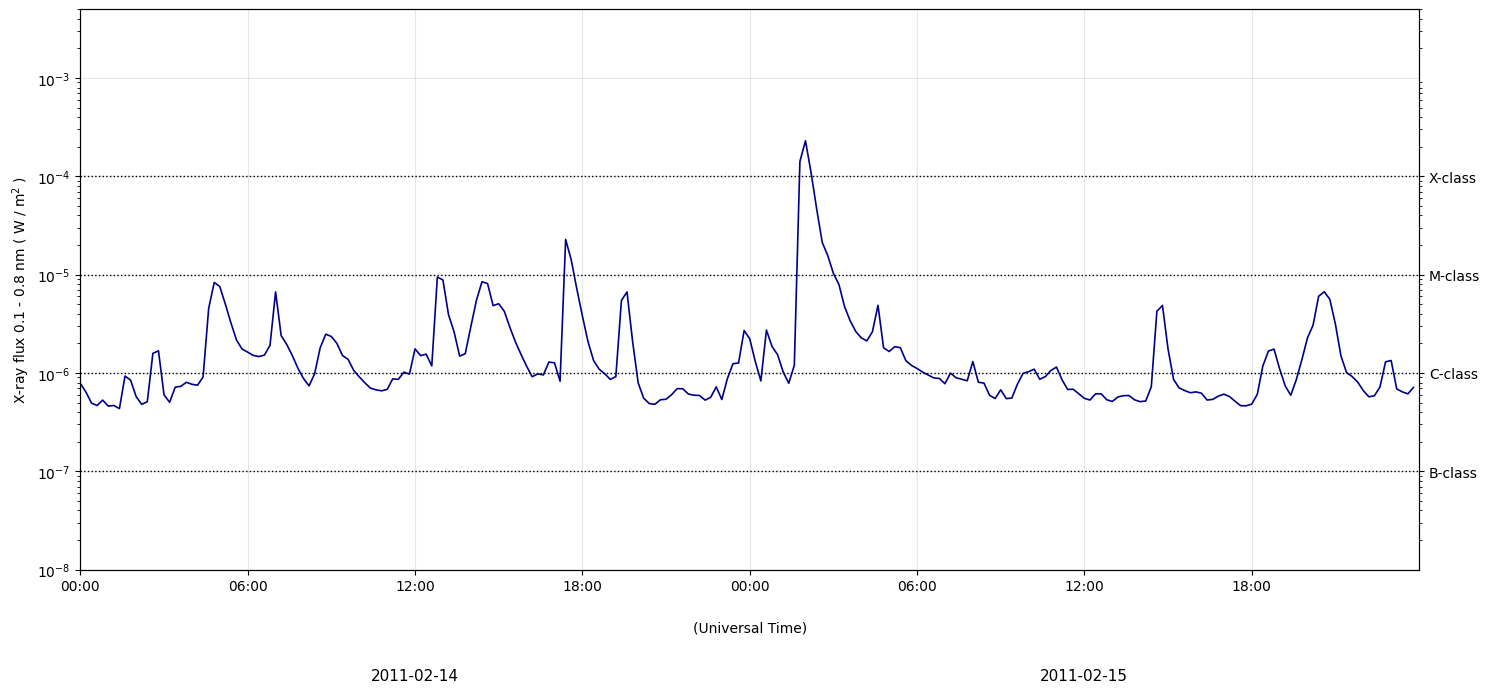

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_filtered['Timestamp'], df_filtered['XR_MAX_plot'], color='darkblue', linewidth=1.2)

ax.set_yscale('log')
ax.set_ylim(1e-8, 5e-3)
ax.set_ylabel('X-ray flux 0.1 - 0.8 nm ( W / m$^2$ )')

# Flare class thresholds
ax.axhline(1e-7, color='black', linestyle='dotted', linewidth=1)
ax.axhline(1e-6, color='black', linestyle='dotted', linewidth=1)
ax.axhline(1e-5, color='black', linestyle='dotted', linewidth=1)
ax.axhline(1e-4, color='black', linestyle='dotted', linewidth=1)

# Twin y-axis for flare class labels
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([1e-7, 1e-6, 1e-5, 1e-4])
ax2.set_yticklabels(['B-class', 'C-class', 'M-class', 'X-class'])

ax.set_xlim(plot_start_time, plot_end_time)
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.text(plot_start_time + pd.Timedelta(hours=12), 1e-9, '2011-02-14', ha='center', va='top', fontsize=11)
ax.text(plot_end_time - pd.Timedelta(hours=12), 1e-9, '2011-02-15', ha='center', va='top', fontsize=11)
ax.set_xlabel("(Universal Time)", labelpad=20)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Conclusion:**  
*The plot above shows the X-ray flux evolution during the X-class flare event on February 14-15, 2011. The flux crosses the standard thresholds for B, C, M, and X-class flares, illustrating the intensity and timing of the event. This visualization provides context for subsequent analysis of magnetic parameters and flare productivity.*

# Experiment 2: Magnetic Helicity and Flare Class Distribution  
## Fixed-Week Analysis with Location Constraints (March 8–15, 2011)

**Aim:**  
To investigate the relationship between total unsigned current helicity (TOTUSJH) and solar flare class during a week containing an X-class flare, focusing on a specific region of the Sun.  
We apply spatial and temporal constraints to isolate flare events and visualize their distribution, highlighting the X-class flare on March 9, 2011.

In [17]:
# Convert timestamp to datetime
df_swan_actual['Timestamp'] = pd.to_datetime(df_swan_actual['Timestamp'])

# Define location constraints for filtering
LAT_MIN_CONSTRAINT = -10
LAT_MAX_CONSTRAINT = 30
LON_MIN_CONSTRAINT = -10
LON_MAX_CONSTRAINT = 30

# Define time constraints (specific time window if needed)
TIME_START = "00:00:00"
TIME_END = "23:59:59"

# Use the same fixed week for all analysis
start_date = pd.to_datetime('2011-03-08')
end_date = pd.to_datetime('2011-03-15')

In [ ]:
# Filter data for the fixed week
week_data = df_swan_actual[
    (df_swan_actual['Timestamp'] >= start_date) &
    (df_swan_actual['Timestamp'] <= end_date)
].copy()

In [18]:
# Apply time constraints
week_data = week_data[
    (week_data['Timestamp'].dt.time >= pd.to_datetime(TIME_START).time()) &
    (week_data['Timestamp'].dt.time <= pd.to_datetime(TIME_END).time())
]

# Apply location constraints
week_data = week_data[
    (week_data['LAT_MIN'] >= LAT_MIN_CONSTRAINT) &
    (week_data['LAT_MAX'] <= LAT_MAX_CONSTRAINT) &
    (week_data['LON_MIN'] >= LON_MIN_CONSTRAINT) &
    (week_data['LON_MAX'] <= LON_MAX_CONSTRAINT)
]

In [19]:
# Assign flare classes
week_data['flare_class'] = None
week_data.loc[week_data['BFLARE'] > 0, 'flare_class'] = 'B'
week_data.loc[week_data['CFLARE'] > 0, 'flare_class'] = 'C'
week_data.loc[week_data['MFLARE'] > 0, 'flare_class'] = 'M'
week_data.loc[week_data['XFLARE'] > 0, 'flare_class'] = 'X'

In [20]:
# Filter to only include records with flare activity
data = week_data.dropna(subset=['flare_class'])

# Target flare date for reference
target_flare_date = datetime(2011, 3, 9)
hover_cols = [
    'LAT_MIN','LON_MIN','LAT_MAX','LON_MAX',
    'TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH',
    'BFLARE','CFLARE','MFLARE','XFLARE'
]

In [21]:
# Only the main panel
fig = px.scatter(
    data, x='Timestamp', y='TOTUSJH',
    color='flare_class',
    hover_data=hover_cols,
    title=f'Helicity vs Time ({start_date.date()} to {end_date.date()})'
)
fig.add_vline(x=target_flare_date, line_dash="dash", line_color="red")
fig.show()

**Conclusion:**  
*The interactive plots above reveal the temporal distribution of flare classes and their associated helicity values within a constrained region and week. The X-class flare on March 9, 2011, is clearly highlighted, allowing for comparison with other flare classes and assessment of magnetic helicity trends leading up to and following the event.*

In [22]:
start_date = pd.to_datetime('2011-03-09')
end_date = pd.to_datetime('2011-03-10')

In [23]:
# --- 1. Find a Target X-Flare and its Properties ---
# Find the first occurrence of an X-class flare to define our analysis window
x_flare_events = df_swan_actual[df_swan_actual['XFLARE'] > 0].sort_values('Timestamp')

if not x_flare_events.empty:
    target_event = x_flare_events.iloc[0]
    target_date = target_event['Timestamp']

    # Define location constraints based on this specific flare's active region
    LAT_MIN_CONSTRAINT = target_event['LAT_MIN']
    LAT_MAX_CONSTRAINT = target_event['LAT_MAX']
    LON_MIN_CONSTRAINT = target_event['LON_MIN']
    LON_MAX_CONSTRAINT = target_event['LON_MAX']

    # # Define time window: ±5 days around the flare
    # start_date = target_date - timedelta(days=5)
    # end_date = target_date + timedelta(days=5)

    print(f"Target X-Flare identified on: {target_date.date()}")
    print(f"Active Region Location (Lat/Lon): [{LAT_MIN_CONSTRAINT:.2f}, {LAT_MAX_CONSTRAINT:.2f}] / [{LON_MIN_CONSTRAINT:.2f}, {LON_MAX_CONSTRAINT:.2f}]")
    print(f"Analysis window: {start_date.date()} to {end_date.date()}")

    # --- 2. Filter Data based on the Spatio-Temporal Window ---
    # Filter the main dataframe for this specific time and location window
    region_data = df_swan_actual[
        (df_swan_actual['Timestamp'] >= start_date) &
        (df_swan_actual['Timestamp'] <= end_date) &
        (df_swan_actual['LAT_MIN'] >= LAT_MIN_CONSTRAINT - 1) & # Add a small buffer
        (df_swan_actual['LAT_MAX'] <= LAT_MAX_CONSTRAINT + 1) &
        (df_swan_actual['LON_MIN'] >= LON_MIN_CONSTRAINT - 1) &
        (df_swan_actual['LON_MAX'] <= LON_MAX_CONSTRAINT + 1)
    ].copy()

    # --- 3. Classify and Analyze Flares in the Window ---
    # Assign flare classes (prioritize higher classes)
    region_data['flare_class'] = None
    region_data.loc[region_data['BFLARE'] > 0, 'flare_class'] = 'B'
    region_data.loc[region_data['CFLARE'] > 0, 'flare_class'] = 'C'
    region_data.loc[region_data['MFLARE'] > 0, 'flare_class'] = 'M'
    region_data.loc[region_data['XFLARE'] > 0, 'flare_class'] = 'X'

    # Filter to only include records with flare activity
    data = region_data.dropna(subset=['flare_class'])

    # --- 4. Visualize the Results ---
    if not data.empty:
        hover_cols = [
            'TOTUSJH', 'TOTPOT', 'MEANSHR', 'XR_MAX',
            'LAT_MIN', 'LON_MIN', 'LAT_MAX', 'LON_MAX',
            'BFLARE', 'CFLARE', 'MFLARE', 'XFLARE'
        ]

        fig = make_subplots(rows=1, cols=1)

        scatter = px.scatter(
            data, x='Timestamp', y='TOTUSJH',
            color='flare_class',
            hover_data=hover_cols,
            title=f'Helicity Evolution Around X-Flare of {target_date.date()}<br><sup>Region: Lat({LAT_MIN_CONSTRAINT:.1f},{LAT_MAX_CONSTRAINT:.1f}), Lon({LON_MIN_CONSTRAINT:.1f},{LON_MAX_CONSTRAINT:.1f})</sup>',
            color_discrete_map={'B': 'blue', 'C': 'green', 'M': 'orange', 'X': 'red'}
        )

        for trace in scatter.data:
            fig.add_trace(trace)
        # Add the vertical line
        fig.add_vline(
            x=target_date,
            line_dash="dash",
            line_color="red"
        )
        fig.add_annotation(
    x=target_date,
    y=target_event['XFLARE_LABEL_LOC'],
    text="X-Flare Peak",
    showarrow=True,
    arrowhead=1,
    yanchor="bottom",
    font=dict(color="red", size=40),
    bgcolor="rgba(255,255,255,0.8)"
)
        fig.update_layout(height=600, showlegend=True, yaxis_title="Total Unsigned Current Helicity (TOTUSJH)")
        fig.update_xaxes(range=[start_date, end_date])
        fig.show()
    else:
        print("\nNo flare data found for the specified spatio-temporal window.")
else:
    print("No X-class flares found in the dataset to analyze.")

Target X-Flare identified on: 2011-03-09
Active Region Location (Lat/Lon): [4.12, 14.64] / [1.39, 19.80]
Analysis window: 2011-03-09 to 2011-03-10
